In [1]:
import numpy as np
import yaml
import shutil
import uuid
from tensorflow.keras import backend as K
from nn_tools import read_count
import tensorflow as tf
from data_bank import data_selector
import model_builders as mb
import os
from os.path import join
import matplotlib.pyplot as plt
import sys
from adversarial_attacks.spsa import spsa, spsa_T1
from adversarial_attacks.df_attacks import attack_network
from tensorflow.keras.applications.resnet50 import preprocess_input as res_prep
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_prep
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [2]:
def create_adversarial_pattern(input_image, input_label, pretrained_model):

    loss_object = tf.keras.losses.binary_crossentropy
    with tf.GradientTape() as tape:
        image = np.expand_dims(input_image, axis = 0)
        image = tf.convert_to_tensor(image)
        tape.watch(image)
        prediction = pretrained_model(image)
        loss = loss_object(input_label, prediction)
    gradient =  tape.gradient(loss,image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def put_in_range(img):
    
    out = np.zeros([1,224,224,1])
    
    for i in range(224):
        for j in range(224):
            if img[0,i,j]>1:
                out[0,i,j,0]=1
            elif img[0,i,j]<0:
                out[0,i,j,0] = 0
            else:
                out[0,i,j,0] = img[0,i,j,0]
    return out

In [3]:
#Setup model

'''
need to load model
need to load training data
perform adversarial attack
'''

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

configfile = 'config_adv.yml'
with open(configfile) as ymlfile:
    cgf = yaml.load(ymlfile, Loader =yaml.SafeLoader)

# Set up computational resource 
use_gpu = cgf['COMPUTER_SETUP']['use_gpu']
print("""\nCOMPUTER SETUP
Use gpu: {}""".format(use_gpu))
if use_gpu:
    compute_node = cgf['COMPUTER_SETUP']['compute_node']
    os.environ["CUDA_VISIBLE_DEVICES"]= "%d" % (compute_node)
    print('Compute node: {}'.format(compute_node))
else: 
    os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

# Turn on soft memory allocation
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.log_device_placement = False
sess = tf.compat.v1.Session(config=tf_config)
#K.v1.set_session(sess)


COMPUTER SETUP
Use gpu: True
Compute node: 2


In [6]:
%%time
data_loader = data_selector(cgf['DATASET']['name'], cgf['DATASET']['arguments'])

data, labels, diff = data_loader.load_data() 

CPU times: user 16.8 ms, sys: 26.2 s, total: 26.2 s
Wall time: 58.7 s


In [7]:
data = data[:3000,:,:]
labels = labels[:3000]

'''
data = np.load(cgf["DATASET"]["arguments"]["images"])
labels = np.load(cgf["DATASET"]["arguments"]["labels"])
'''

'\ndata = np.load(cgf["DATASET"]["arguments"]["images"])\nlabels = np.load(cgf["DATASET"]["arguments"]["labels"])\n'

In [8]:
# Get input and output shape
input_shape = data.shape[1:]
output_shape = labels.shape[1];
print('input_shape', input_shape)
# Set the default precision 
model_precision = cgf['MODEL_METADATA']['precision']
K.set_floatx(model_precision)

model_id = cgf['MODEL_METADATA']['model_number_arguments']['model_id']
model_path = join('model', str(model_id))
filepath = cgf['MODEL_METADATA']['save_best_model']['arguments']['filepath']
attack = cgf['ATTACK']['name']

original_data = cgf['DATASET']['arguments']['original_images']
adv_data = cgf['DATASET']['arguments']["adv_images"]
adv_labels = cgf['DATASET']['arguments']['adv_labels']
adv_diffs = cgf['DATASET']['arguments']['adv_diffs']

weights_path = join(model_path, filepath)

optimizer = cgf['TRAIN']['optim']['type']
loss_type = cgf['TRAIN']['loss']['type']
metric_list = list(cgf['TRAIN']['metrics'].values())

if loss_type == 'SparseCategoricalCrossentropy':
    loss_type = SparseCategoricalCrossentropy(from_logits=False)
    metric_list = [SparseCategoricalAccuracy()]
    output_shape = 2
    labels = np.reshape(labels, (-1))

model_name = cgf['MODEL']['name']
model_arguments = cgf['MODEL']['arguments']
#model = mb.model_selector(model_name, input_shape, output_shape, model_arguments)

model = tf.keras.models.load_model(weights_path)

# Preprocessing
if model_name =='resnet':
    preprocessing = res_prep
    data = 225*data
    data = data - 122
    labels = np.reshape(labels,(-1))
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
elif model_name == 'vgg16':
    preprocessing = vgg_prep
    data = 225*data
    data = data - 122
    labels = np.reshape(labels,(-1))
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
else:
    preprocessing = None 

model.compile(optimizer=optimizer,
              loss=loss_type,
              metrics = metric_list)

model.trainable = False

input_shape (224, 224, 1)


In [9]:
# Evaluate the model on training data (can also do on test)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on data")
if model_name =='resnet':
    eval_data = tf.cast(data, dtype=tf.float32)
    eval_labels = tf.cast(labels, dtype=tf.float32)
    results = model.evaluate(eval_data, eval_labels, batch_size=50)
elif model_name =='vgg16':
    eval_data = tf.cast(data, dtype=tf.float32)
    eval_labels = tf.cast(labels, dtype=tf.float32)
    results = model.evaluate(eval_data, eval_labels, batch_size=50)
else:
    results = model.evaluate(tf.convert_to_tensor(data), tf.convert_to_tensor(labels), batch_size=50)

print("Loss :{}, Accuracy: {}%.".format(results[0], results[1]))

Evaluate on data
60/60 [==============================] - 103s 2s/step - loss: 2.7092 - sparse_categorical_accuracy: 0.8213
Loss :2.709217498699824, Accuracy: 0.8213333333333334%.


In [10]:
data_loader = data_selector(cgf['DATASET']['name'], cgf['DATASET']['train_arguments'])

data_train, labels_train, diff_train = data_loader.load_data()

# Preprocessing
if model_name =='resnet':
    preprocessing = res_prep
    data_train = 225*data_train
    data_train = data_train-122
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
elif model_name == 'vgg16':
    preprocessing = vgg_prep
    data_train = 225*data_train
    data_train = data_train - 122
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
else:
    preprocessing = None 

# Evaluate the model on training data (can also do on test)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on data")
results = model.evaluate(tf.convert_to_tensor(data_train), tf.convert_to_tensor(labels_train), batch_size=50)
print("Loss :{}, Accuracy: {}%.".format(results[0], results[1]))

Evaluate on data
200/200 [==============================] - 351s 2s/step - loss: 2.5593 - sparse_categorical_accuracy: 0.8309
Loss :2.559323272705078, Accuracy: 0.8309%.


## Check whether a particular attack works

Image number 1.
Image number 2.
Image number 3.
Image number 5.
Image number 7.
Image number 8.
Image number 10.
Image number 11.
Image number 13.
Image number 14.
Image number 16.
Image number 17.
Image number 19.
Image number 20.
Image number 21.
Image number 22.
Image number 23.
Image number 24.
Image number 25.
Image number 26.
Image number 27.
Image number 28.
Image number 30.
Image number 31.
Image number 32.
Image number 33.
Image number 34.
Image number 35.
Image number 37.
Image number 38.
Image number 39.
Image number 40.
Image number 41.
Image number 42.
Image number 43.
Image number 44.
Image number 45.
Image number 46.
Image number 47.
Image number 49.
Image number 50.
Image number 51.
Image number 52.


<Figure size 432x288 with 0 Axes>

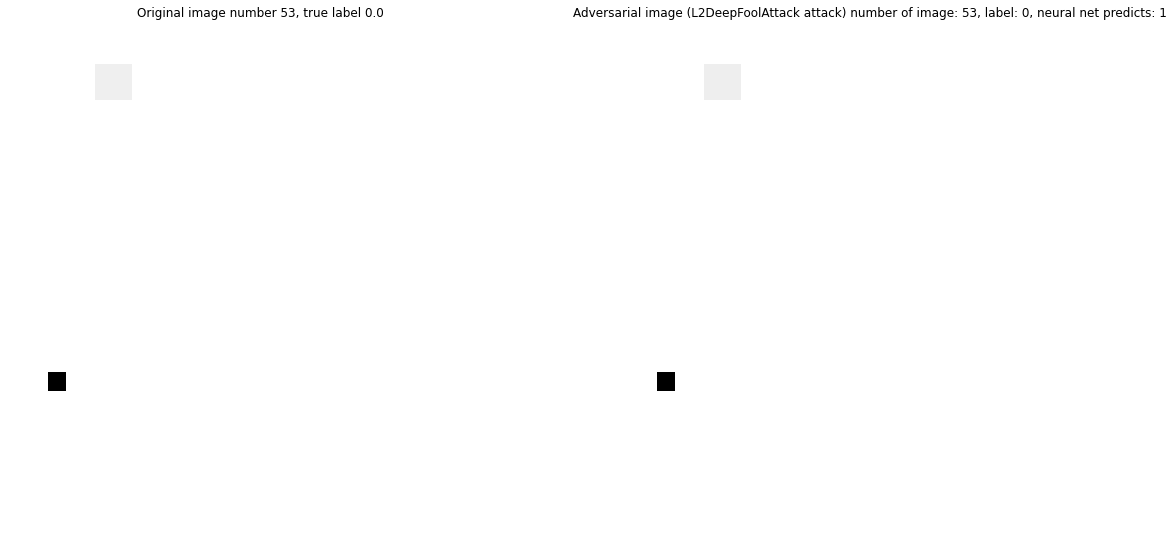

Image number 53.
Image number 54.
Image number 56.
Image number 58.
Image number 59.
Image number 60.
Image number 61.
Image number 63.
Image number 64.
Image number 65.
Image number 66.
Image number 67.
Image number 68.
Image number 69.
Image number 71.
Image number 72.
Image number 73.
Image number 74.
Image number 75.
Image number 76.
Image number 77.
Image number 78.


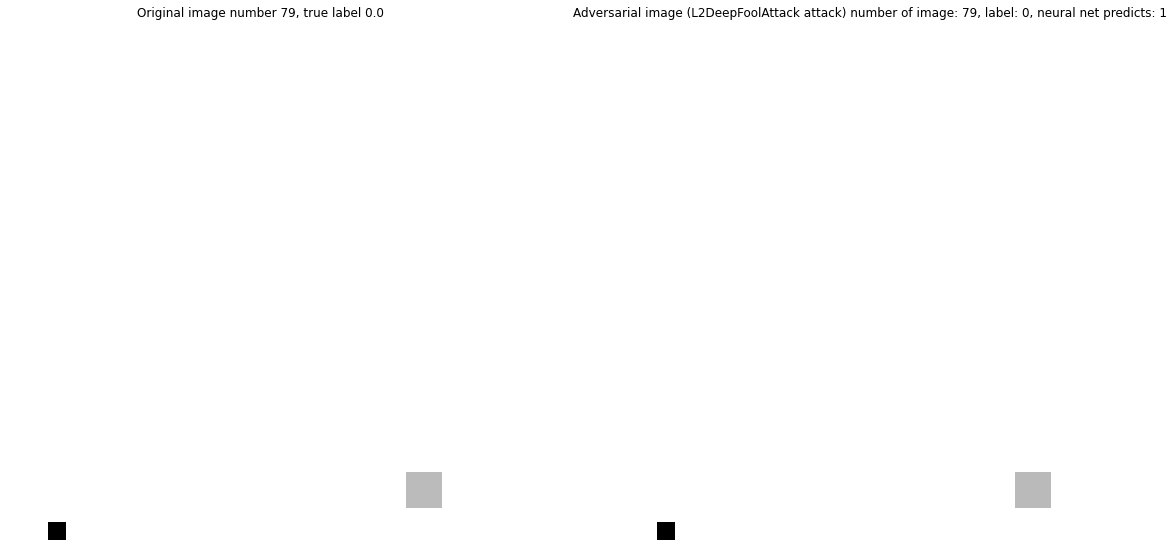

Image number 79.
Image number 80.
Image number 81.
Image number 83.
Image number 84.
Image number 85.
Image number 86.
Image number 87.
Image number 88.
Image number 90.
Image number 91.
Image number 92.
Image number 93.
Image number 94.
Image number 96.
Image number 97.
Image number 98.
Image number 100.
Image number 101.
Image number 102.
Image number 104.


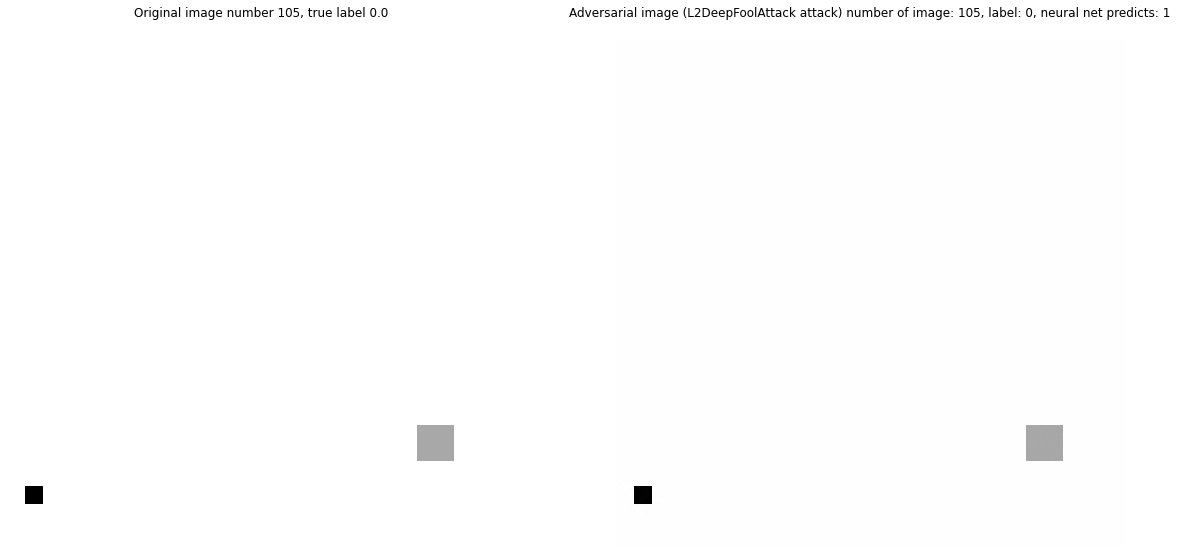

Image number 106.
Image number 107.
Image number 108.
Image number 109.
Image number 110.
Image number 114.
Image number 115.
Image number 116.
Image number 117.
Image number 118.
Image number 119.
Image number 120.
Image number 121.
Image number 124.
Image number 125.
Image number 126.


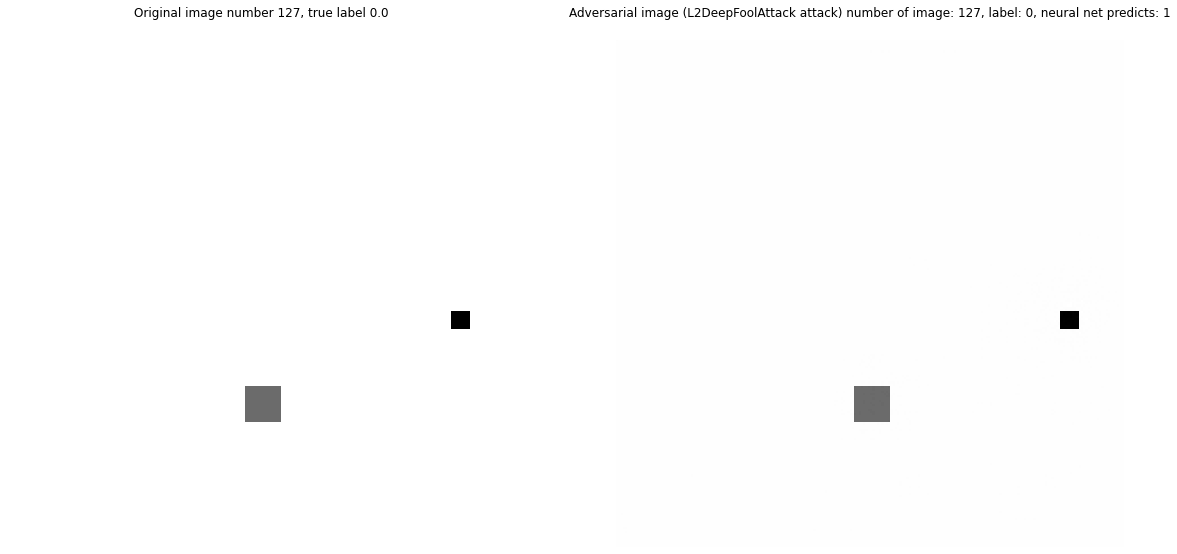

Image number 127.
Image number 130.
Image number 131.
Image number 132.
Image number 133.
Image number 134.
Image number 136.
Image number 137.
Image number 138.
Image number 139.
Image number 140.
Image number 141.
Image number 142.
Image number 144.
Image number 145.
Image number 146.
Image number 147.
Image number 148.
Image number 149.
Image number 150.
Image number 151.
Image number 152.
Image number 153.
Image number 154.
Image number 155.
Image number 156.
Image number 157.
Image number 158.
Image number 159.
Image number 160.
Image number 161.
Image number 162.
Image number 163.
Image number 164.
Image number 165.
Image number 167.
Image number 168.
Image number 170.
Image number 171.
Image number 173.
Image number 174.
Image number 177.
Image number 178.
Image number 179.
Image number 181.
Image number 182.
Image number 183.


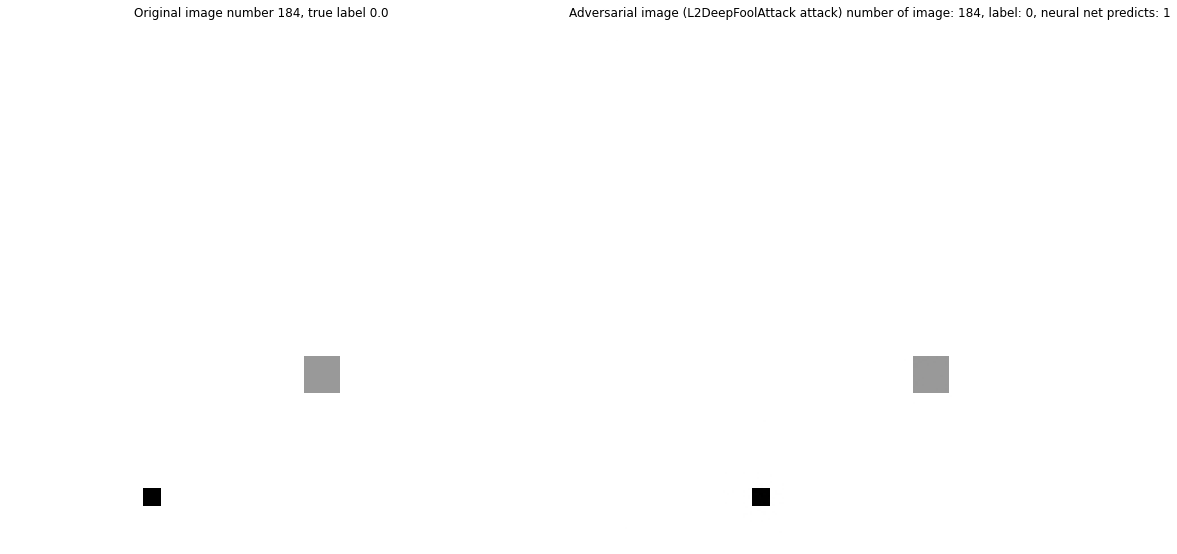

Image number 184.
Image number 185.
Image number 186.
Image number 187.
Image number 188.
Image number 189.
Image number 190.
Image number 191.
Image number 192.
Image number 193.
Image number 194.
Image number 195.
Image number 196.
Image number 197.
Image number 199.
Image number 200.
Image number 201.
Image number 202.
Image number 203.
Image number 204.
Image number 205.
Image number 206.
Image number 207.
Image number 209.
Image number 210.
Image number 211.
Image number 212.
Image number 213.
Image number 214.
Image number 215.
Image number 216.
Image number 217.
Image number 218.
Image number 219.
Image number 220.
Image number 222.
Image number 223.
Image number 224.
Image number 225.
Image number 226.
Image number 227.
Image number 228.
Image number 229.
Image number 230.
Image number 231.
Image number 234.
Image number 235.
Image number 236.
Image number 237.
Image number 238.
Image number 239.
Image number 240.
Image number 241.
Image number 242.
Image number 243.
Image numb

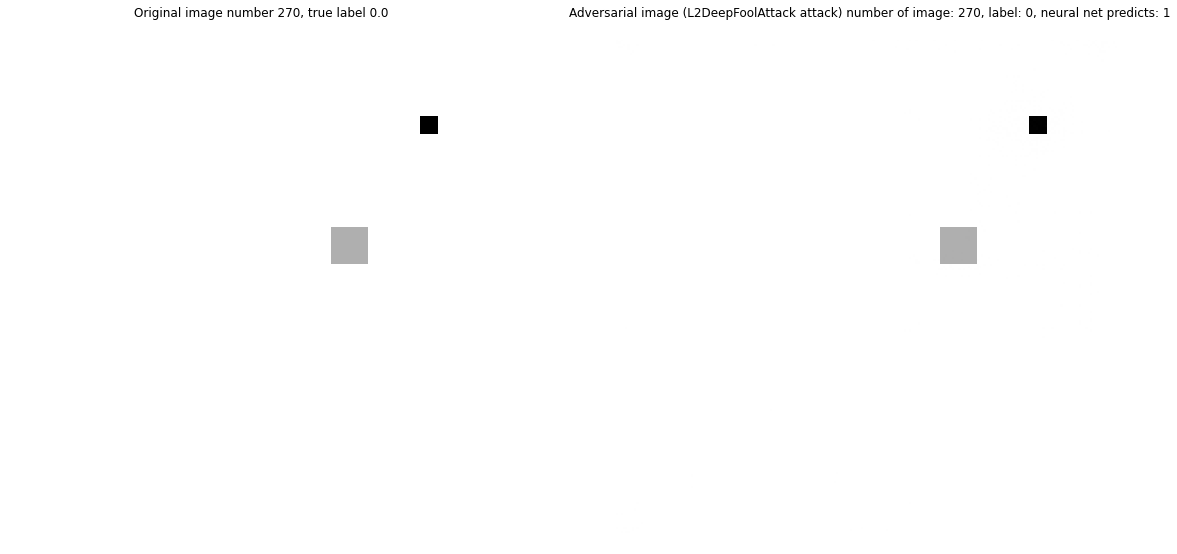

Image number 271.
Image number 272.
Image number 273.
Image number 274.
Image number 275.
Image number 276.
Image number 277.
Image number 279.
Image number 281.
Image number 284.
Image number 285.
Image number 286.
Image number 287.
Image number 288.
Image number 289.
Image number 290.
Image number 291.
Image number 293.
Image number 294.
Image number 295.
Image number 297.
Image number 302.
Image number 303.
Image number 304.
Image number 305.
Image number 307.
Image number 308.
Image number 309.
Image number 312.
Image number 313.


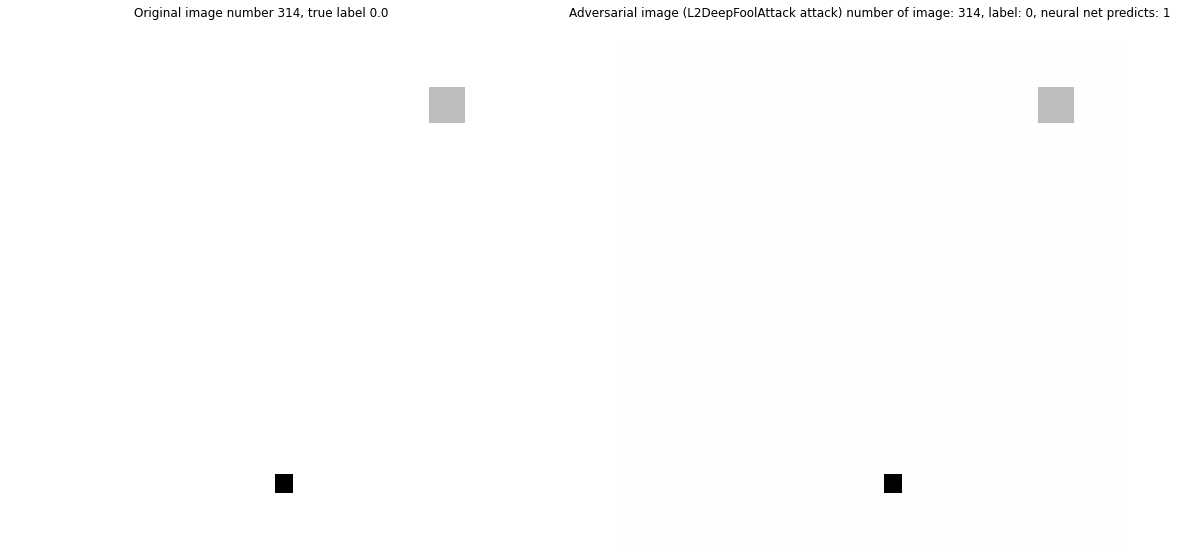

Image number 314.
Image number 315.
Image number 316.
Image number 317.
Image number 318.
Image number 319.
Image number 321.
Image number 322.
Image number 323.
Image number 325.


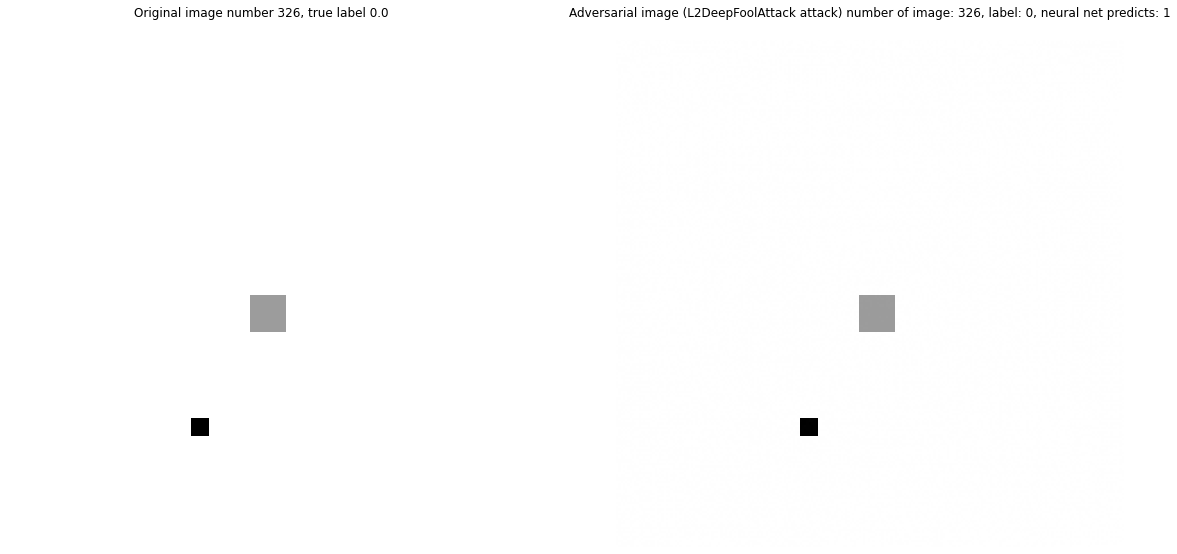

Image number 326.
Image number 327.
Image number 329.
Image number 330.


KeyboardInterrupt: 

In [11]:
# Do adversarial attacks on training data (can also do on test)

originals = []
adversarials = []
diffs = []
adv_lab = []
ans = []

plt.figure()

data_size = 500

if attack == 'spsa':
    for i in range(data_size): 
        colors = set(data[i].flatten())
        colors = [colors.pop(),colors.pop(),colors.pop()]
        color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
        lower = min(color_diff)

        epsilon = lower/4
        delta = epsilon/8
        alpha = delta
        T = 20
        n = 5

        candidates = spsa_T1(model, data[i], delta, alpha, n, epsilon, T)
        for cand in candidates:
            cand = np.expand_dims(cand, axis=0)
            if round(model.predict(cand)[0,0]) !=  labels[i][0]:
                adversarials.append(cand)
                adv_lab.append(labels[i])

else:
    for i in range(data_size): 
        if np.argmax(model.predict(tf.convert_to_tensor(data[i].reshape((1, 224, 224, 1))))) == int(labels[i]):
            print("Image number {}.".format(i))
            # Only images that get correctly labeled in the first place
            colors = set(data[i].flatten())
            # print('The original shades are {}'.format(colors))
            colors = [colors.pop(),colors.pop(),colors.pop()]
            color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
            lower = min(color_diff)

            epsilon = lower/4

            #_, clipped, _= attack_selector(attack, model, preprocessing, data[i], labels[i], epsilon)
            _, cand, _= attack_network(attack, model, model_name, preprocessing, data[i], labels[i], epsilon)

            # print('The ones generated by the adversarial attack are {}'.format(set(cand.flatten())))


            if np.argmax(model.predict(cand)) !=  int(labels[i]):
                # Where adversarial images succeed in making the initial correct prediciton wrong


                img_to_show = (np.reshape(data[i],(224,224)) +122)/255
                cand_to_show = (np.reshape(cand,(224,224)) +122)/255
                
                originals.append(img_to_show)
                adversarials.append(cand_to_show)
                adv_lab.append(labels[i])
                diffs.append(diff[i])
                ans.append(np.argmax(model.predict(cand)))
                
                
                plt.figure(figsize=(20,10))

                plt.subplot(121)
                plt.matshow(img_to_show, cmap = 'gray', fignum=False)
                plt.axis('off')
                plt.title('Original image number {}, true label {}'.format(i+1, labels[i]))

                plt.subplot(122)
                plt.matshow(cand_to_show, cmap = 'gray', fignum=False)
                plt.axis('off')
                plt.title('Adversarial image ({} attack) number of image: {}, label: {}, neural net predicts: {}'.format(attack, i+1, int(labels[i]), np.argmax(model.predict(cand))))

                plt.show()



    
np.save(original_data, originals)
np.save(adv_data, adversarials)
np.save(adv_labels, adv_lab)

## Check whether at least one attack works

In [13]:
# Do adversarial attacks on training data (can also do on test)
attack_types = [ 'FGSM', 'L2PGD', 'LinfPGD', 'PGD', 'L2DeepFoolAttack', 'LinfDeepFoolAttack'] # 'FGM',
attack_type_success = dict((att, 0) for att in attack_types)
image_vulnerabilities = dict()
originals = []
adversarials = []
adv_lab = []
ans = []
diffs = []
success = 0

plt.figure()

data_size = 500

if attack == 'spsa':
    for i in range(data_size): 
        colors = set(data[i].flatten())
        colors = [colors.pop(),colors.pop(),colors.pop()]
        color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
        lower = min(color_diff)

        epsilon = lower/4
        delta = epsilon/8
        alpha = delta
        T = 20
        n = 5

        candidates = spsa_T1(model, data[i], delta, alpha, n, epsilon, T)
        for cand in candidates:
            cand = np.expand_dims(cand, axis=0)
            if round(model.predict(cand)[0,0]) !=  labels[i][0]:
                adversarials.append(cand)
                adv_lab.append(labels[i])

else:
    for i in range(data_size): 
        image_vulnerabilities['{}'.format(i)] = False
        if np.argmax(model.predict(tf.convert_to_tensor(data[i].reshape((1, 224, 224, 1))))) == int(labels[i]):
            
            # Only images that get correctly labeled in the first place
            colors = set(data[i].flatten())
            # print('The original shades are {}'.format(colors))
            colors = [colors.pop(),colors.pop(),colors.pop()]
            color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
            lower = min(color_diff)

            epsilon = lower/4

            for attack_choice in attack_types:
                #_, clipped, _= attack_selector(attack, model, preprocessing, data[i], labels[i], epsilon)
                _, cand, _= attack_network(attack_choice, model, model_name, preprocessing, data[i], labels[i], epsilon)

                # print('The ones generated by the adversarial attack are {}'.format(set(cand.flatten())))


                if np.argmax(model.predict(cand)) !=  int(labels[i]):
                    
                    attack_type_success[attack_choice] += 1
                    image_vulnerabilities['{}'.format(i)] = True
                    
                    img_to_show = (np.reshape(data[i],(224,224)) +122)/255
                    cand_to_show = (np.reshape(cand,(224,224)) +122)/255
                
                    originals.append(img_to_show)
                    adversarials.append(cand_to_show)
                    adv_lab.append(labels[i])
                    diffs.append(diff[i])
                    ans.append(np.argmax(model.predict(cand)))
                    
            if image_vulnerabilities['{}'.format(i)]:
                
                success += 1
            
            if i%100==0:
                
                print(i)
                
                    
f = open("attack_type_success.txt","w")
f.write( str(attack_type_success) )
f.close()

g = open("image_vulnerabilities.txt","w")
g.write( str(image_vulnerabilities) )
g.close()
    
np.save(original_data, originals[:300])
np.save(adv_data, adversarials[:300])
np.save(adv_labels, adv_lab[:300])
np.save(adv_diffs, diffs[:300])

print('Adversarial susceptibility : {:.2f}%'.format(100*success/data_size))

100
200
400


NameError: name 'adv_diffs' is not defined

<Figure size 432x288 with 0 Axes>

In [14]:
# For FC3 381 and 629 in training become adversarial with LinfPGD
# For CNN4 38, 101, 313, 354, 562, 623, 629, 731, 839, 1013, 1071, 1091, 
# 1130, 1266, 1359, 1606, 1640, 1642, 1716, 1811, 1969, 2003, 2017, 2240, 2287, 2290, 2452, 2458, 2652, 2749, 2779
# 2947, 2955, 
attack_type_success

{'FGSM': 227,
 'L2PGD': 14,
 'LinfPGD': 339,
 'PGD': 339,
 'L2DeepFoolAttack': 12,
 'LinfDeepFoolAttack': 326}

In [17]:
print('Adversarial susceptibility : {:.2f}%'.format(100*success/data_size))

Adversarial susceptibility : 67.80%


In [16]:
adv_diffs = cgf['DATASET']['arguments']['adv_diffs']
np.save(adv_diffs, diffs[:300])

In [ ]:
for j in range(10):
    
    plt.figure(figsize=(20,10))

    plt.subplot(122)
    plt.matshow(originals[j], cmap = 'gray', fignum=False)
    plt.axis('off')
    plt.title('Adversarial image ({} attack) number of image: {}, label: {}, neural net predicts: {}'.format(attack, i+1, int(labels[i]), np.argmax(model.predict(cand))))

    plt.show()

for i in range(300):
    
                plt.figure(figsize=(20,10))

                plt.subplot(122)
                plt.matshow(adversarials[i], cmap = 'gray', fignum=False)
                plt.axis('off')
                plt.title('Adversarial image ({} attack) number of image: {}, label: {}, neural net predicts: {}'.format(attack, i+1, int(labels[i]), np.argmax(model.predict(cand))))

                plt.show()

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(122)
plt.matshow(data_train[0], cmap = 'gray', fignum=False)
plt.axis('off')
plt.title('Adversarial image ({} attack) number of image: {}, label: {}, neural net predicts: {}'.format(attack, i+1, int(labels[i]), np.argmax(model.predict(cand))))

plt.show()

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
exit()